In [1]:
import matplotlib.pyplot as pyplot
import numpy as N
import numpy.random as NR
import seaborn
import pandas as P
import importlib
import json
import shutil
from pathlib import Path

import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.backend as KB
import tensorflow.keras.initializers as KI
import tensorflow.keras.layers as KL
import tensorflow.keras.models as KM
import tensorflow.keras.optimizers as KO
import tensorflow.keras.regularizers as KR
import tensorflow_probability as tfp

import tqdm
import tqdm.notebook

seaborn.set_style('whitegrid')

In [2]:
tf_devices = tf.config.list_logical_devices('GPU')
#tf.config.set_soft_device_placement(True)
#tf_strategy = tf.distribute.MirroredStrategy(tf_devices)
#print(f"{tf_strategy.num_replicas_in_sync} replica on devices {tf_devices}")

In [3]:
basepath = Path('models/Chen19Mod')
with open(basepath / 'config.json', 'r') as f:
    config = json.load(f)
config

{'seed': 0,
 'nAssets': 1,
 'x0': [0.5, 1.5],
 'strike': [0.5, 1.5],
 'maturity': [1.0, 3.0],
 'dividend': [0, 0.05]}

In [4]:
NR.seed(config['seed'])
tf.random.set_seed(config['seed'])

nSamples = 16384
nAssets = config['nAssets']
def uniform_rand(key, size=(nSamples,)):
    return NR.uniform(key[0], key[1], size=size).astype("float32")

In [5]:
import finmod.american_option as FA
importlib.reload(FA)

with tf.device('/device:cpu:0'):
    NR.seed(config['seed'])
    
    option_train = FA.AmericanOption(nSamples=nSamples,
                               nAssets=nAssets,
                               x0=1.0 * N.ones((nSamples,1),dtype='float32'), #uniform_rand(config['x0'], (nSamples, nAssets)),
                               strike=uniform_rand(config['strike']),
                               maturity=uniform_rand(config['maturity']),
                               dividend=uniform_rand(config['dividend']),
                               direction='put')
    
    option_val = FA.AmericanOption(nSamples=nSamples,
                               nAssets=nAssets,
                               x0=1.0 * N.ones((nSamples,1),dtype='float32'), #x0,
                               strike=uniform_rand(config['strike']),
                               maturity=uniform_rand(config['maturity']),
                               dividend=uniform_rand(config['dividend']),
                               direction='put')
    option_train.populate()
    option_val.populate()
    
#loss_func = option_train.get_loss_bsde_square_func()

# Model

In [6]:

def _cond_broadcast(x, idx):
    if isinstance(x, float):
        return x #tf.ones([len(idx),], dtype=option.dtype) * x
    else:
        return x[idx]
        
class Model(KM.Model):
    
    def __init__(self, name, option):
        super(Model, self).__init__(name=name)
        
        #in1 = KL.Input((option.nAssets,), name="X Input")
        #in2 = KL.Input((3,), name="Y/S/M Input")
        #in3 = KL.Input((option.nAssets,), name="dYdX Input")
        #self.option = option
        
        self.nSteps = option.nSteps
        
        self.l_concat = KL.Concatenate(name="Concatenate")
        self.core = []
        
        nLayers = 5
        for i in range(1, nLayers):
            lb = KL.BatchNormalization(name=f"BN{i}")
            ld = self._dense_layer(name=f"Dense{i}", option=option)
            self.core.append(lb)
            self.core.append(ld)
            
        self.core.append(self._dense_layer("DenseO", option=option, d=1, final=True))
        
        self.core = KM.Sequential(self.core, name=name+"_core")
        
        # Shape check
        self([
            tf.zeros([8, option.nAssets]),
            tf.zeros([8, 2]),
            tf.zeros([8, option.nAssets]),
            tf.zeros([8, 2]),
        ])
        
    def _dense_layer(self, name, option, d=None, final=False):
        nAssets = option.nAssets
        if d is None:
            d = (nAssets + 1) * 10
        stddev = 1.0
        lim = stddev / (nAssets + d)
        return KL.Dense(d, \
                        name=name, \
                        kernel_initializer=KI.RandomUniform(-lim, lim), \
                        bias_initializer=KI.Zeros() if final else KI.RandomUniform(-lim, lim), \
                        kernel_regularizer=KR.l2(1e-4), \
                        activation=None if final else 'relu')
    
    def save(self, path):
        Path(path).mkdir(parents=True, exist_ok=True)
        self.core.save_weights(path / 'core.h5')
        
    def load(self, path):
        self.core.load_weights(path / 'core.h5')
    
    @tf.function
    def call(self, inputs):
        """
        x: (..., nAssets)
        scalars: (..., 2)
        dy_prev_dx: (..., nAssets)
        covariates: (..., 2)
        """
        x, scalars, dy_prev_dx, covariates = inputs
        #print(f"Shapes: x={x.shape}, s={scalars.shape}, dydx={dy_prev_dx.shape}")
        
        # Do not feed dT in
        out = self.l_concat([x, covariates[...,:1], scalars, dy_prev_dx])
        out = self.core(out)
            
        z = out #tf.expand_dims(out, axis=-1)
        # y[n] = y[n-1] + dT * z
        y = covariates[..., 0] + covariates[..., 1] * z
        dydx_1, = tf.gradients(y, x)
        dydy_prev, = tf.gradients(y, dy_prev_dx)
        dydx = dydx_1 + dydy_prev * dy_prev_dx
        dyds, = tf.gradients(y, scalars)
        
        return y[...,0], dydx, z[...,0], dyds
    


with tf.device(tf_devices[0]):
    model = Model("Chen19-Modified", option_train)
model.core.summary()

Model: "Chen19-Modified_core"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
BN1 (BatchNormalization)     (8, 5)                    20        
_________________________________________________________________
Dense1 (Dense)               (8, 20)                   120       
_________________________________________________________________
BN2 (BatchNormalization)     (8, 20)                   80        
_________________________________________________________________
Dense2 (Dense)               (8, 20)                   420       
_________________________________________________________________
BN3 (BatchNormalization)     (8, 20)                   80        
_________________________________________________________________
Dense3 (Dense)               (8, 20)                   420       
_________________________________________________________________
BN4 (BatchNormalization)     (8, 20)          

In [7]:
modelPath = Path('models/Chen19Mod/m-1219')

In [8]:

def model_eval(model, idx, option, controlTol=0.01, nu=0.5, arbitragePenalty=0.5, training=False):

    shape_s = [len(idx),]

    opt_p = tf.convert_to_tensor(option.opt_p[idx])
    strike = tf.broadcast_to(_cond_broadcast(option.strike, idx), shape_s)
    dT = tf.expand_dims(_cond_broadcast(option.dT, idx), -1)
    mu = tf.expand_dims(_cond_broadcast(option.mu, idx), -1)
    decay = tf.math.exp(_cond_broadcast(-option.ir * option.dT, idx))

    vPrev = opt_p[..., -1]
    #v = tf.convert_to_tensor(option.opt_p[:, -1])
    v = None
    y    = tf.convert_to_tensor(option.opt_y[idx, -1])
    dydx = tf.convert_to_tensor(option.opt_dydx[idx, -1, :])
    euro = tf.convert_to_tensor(option.opt_euro[idx, :-1])
    dedk = tf.convert_to_tensor(option.opt_dedk[idx, :-1])

    totalLoss = tf.zeros([], dtype=option.dtype)

    @tf.function
    def loss_func(vP, dA, y, dydx, d):
        """
        Chen19, (12)
        """
        r = y / d + tf.reduce_sum(dA * dydx, axis=-1) - vP
        return r ** 2
    def loss_arbitrage_func(v, dydk):
        """
        Cox13, Theorem 2.3
        """
        condIII = tf.maximum(euro[:, step], opt_p[:, step])
        condIII = tf.nn.relu(condIII - v)
        
        condII = tf.nn.relu((dedk[:, step] * strike - euro[:, step]) - (dydk * strike - v))
        return condIII + condII
        
        

    list_loss = []
    list_loss_arbitrage = []
    opt_y = []
    opt_v = []
    list_z = []
    flags = []
    for step in reversed(range(option.nSteps)):
        x  = tf.convert_to_tensor(option.x[idx, step, :])
        dA = tf.convert_to_tensor(option.x[idx, step+1, :]) - tf.math.exp(mu * dT) * x

        #v    = tf.convert_to_tensor(option.opt_v[idx, step])
        #y    = tf.convert_to_tensor(option.opt_y[idx, step])
        #dydx = tf.convert_to_tensor(option.opt_dydx[idx, step, :])

        maturity = (option.nSteps - step) * dT[..., 0]

        scalars = tf.stack([strike, maturity], axis=-1)
        covariates = tf.stack([y, dT[..., 0]], axis=-1)

        y, dydx, z, dyds = model([x, scalars, dydx, covariates], training=training)
        dydk = dyds[..., 0]
        
        #print(f"v={v.shape}, dA={dA.shape}, y={y.shape}, dydx={dydx.shape}")
        # Chen19, (34). True indicates continue
        flag = (y > (1 + controlTol) * opt_p[:, step]) | \
                (opt_p[:, step] < option.payoffTol)
        #flag = tf.ones((len(idx),), dtype=bool) # European option override
        # Chen19, (38)
        v = tf.where(flag,\
            nu * y + (1 - nu) * vPrev * decay, \
            opt_p[:, step])
        
        
        loss = loss_func(vPrev, dA, y, dydx, decay)
        loss_arbitrage = loss_arbitrage_func(v, dydk)
        totalLoss += tf.reduce_mean(loss)# + arbitragePenalty * tf.reduce_mean(loss_arbitrage)

        
        # Update the next iteration

        vPrev = tf.stop_gradient(v) # Prevent BPTT and makes training much faster


        # Save history
        list_loss.append(loss.numpy())
        list_loss_arbitrage.append(loss_arbitrage.numpy())
        opt_y.append(y.numpy())
        opt_v.append(v.numpy())
        list_z.append(z.numpy())
        flags.append(flag.numpy())

    totalLoss /= option.nSteps
    list_loss = N.stack(list_loss)[::-1].T
    list_loss_arbitrage = N.stack(list_loss_arbitrage)[::-1].T
    opt_y = N.stack(opt_y)[::-1].T
    opt_v = N.stack(opt_v)[::-1].T
    list_z = N.stack(list_z)[::-1].T
    flags = N.stack(flags)[::-1].T
    return totalLoss, (opt_v, opt_y), (list_loss, list_loss_arbitrage, list_z, flags)

## Training

In [9]:
nEpochs = 10
batchsize = 64
assert nSamples % batchsize == 0

sched = KO.schedules.ExponentialDecay(0.001, 50, 0.96)
opt = KO.Adam()
hist = P.DataFrame()
if modelPath.exists():
    shutil.rmtree(modelPath)
modelPath.mkdir(parents=True)

arbitragePenalty = 0.0
histGradients = []

NR.seed(0)
tf.random.set_seed(0)

for epoch in tqdm.trange(1,nEpochs+1, desc='Epochs', unit='epoch'):
    KB.set_value(opt.learning_rate, sched(epoch))
    # Shuffle the sample indices in this batch
    sampleOrder = list(range(nSamples))
    NR.shuffle(sampleOrder)
    
    histBatch = P.DataFrame()
    epochGradients = []
    
    for bId in tqdm.trange(nSamples // batchsize, desc='Batch', unit='batch'):
        
        idx = tf.convert_to_tensor(sampleOrder[bId*batchsize:(bId+1)*batchsize], dtype=tf.int32)

        with tf.GradientTape() as tape:

            loss, _, _ = model_eval(model, idx, option_train, arbitragePenalty=arbitragePenalty, training=True)
            loss += sum(model.core.losses)

        grad = tape.gradient(loss, model.trainable_weights)
        grad = [tf.clip_by_value(g, -10.0, 10.0) for g in grad]
        opt.apply_gradients(zip(grad, model.trainable_weights))
        epochGradients.append(N.concatenate([g.numpy().flatten() for g in grad]))
        
        loss_val, _, _ = model_eval(model, idx, option_val, arbitragePenalty=arbitragePenalty, training=False)
        
        histBatch = histBatch.append({
            'batch': bId,
            'loss train': float(loss),
            'loss val': float(loss_val),
        }, ignore_index=True)
        
    metrics = {
        'epoch': epoch,
        'loss train':     N.mean(histBatch['loss train']),
        'loss_std train': N.std(histBatch['loss train']),
        'loss val':     N.mean(histBatch['loss val']),
        'loss_std val': N.std(histBatch['loss val']),
        'learning_rate': float(opt.learning_rate),
    }
    hist = hist.append(metrics, ignore_index=True)
    histGradients.append(N.stack(epochGradients).mean(axis=0))
    
    if epoch % 5 == 0 or epoch == nEpochs:
        model.save(modelPath / f'epoch{epoch:03d}')
    hist.to_csv(modelPath / 'hist.csv', index=False)
    
    print(f"Epoch {epoch}: train loss={metrics['loss train']:.4f}±{metrics['loss_std train']:.4f}, val loss={metrics['loss val']:.4f}±{metrics['loss_std val']:.4f}")

Batch:   0%|          | 0/256 [00:00<?, ?batch/s]

Epoch 1: train loss=0.0597±0.0625, val loss=0.0592±0.0759



Batch:   0%|          | 0/256 [00:00<?, ?batch/s]

Epoch 2: train loss=0.0407±0.0166, val loss=0.0408±0.0166



Batch:   0%|          | 0/256 [00:00<?, ?batch/s]

Epoch 3: train loss=0.0379±0.0152, val loss=0.0403±0.0178



Batch:   0%|          | 0/256 [00:00<?, ?batch/s]

Epoch 4: train loss=0.0373±0.0147, val loss=0.0386±0.0172



Batch:   0%|          | 0/256 [00:00<?, ?batch/s]

Epoch 5: train loss=0.0392±0.0165, val loss=0.0410±0.0176



Batch:   0%|          | 0/256 [00:00<?, ?batch/s]

Epoch 6: train loss=0.0388±0.0172, val loss=0.0375±0.0162



Batch:   0%|          | 0/256 [00:00<?, ?batch/s]

Epoch 7: train loss=0.0375±0.0169, val loss=0.0380±0.0179



Batch:   0%|          | 0/256 [00:00<?, ?batch/s]

Epoch 8: train loss=0.0390±0.0206, val loss=0.0370±0.0161



Batch:   0%|          | 0/256 [00:00<?, ?batch/s]

Epoch 9: train loss=0.0416±0.0246, val loss=0.0434±0.0267



Epochs: 100%|██████████| 10/10 [13:07<00:00, 78.71s/epoch]

Epoch 10: train loss=0.0392±0.0183, val loss=0.0389±0.0182


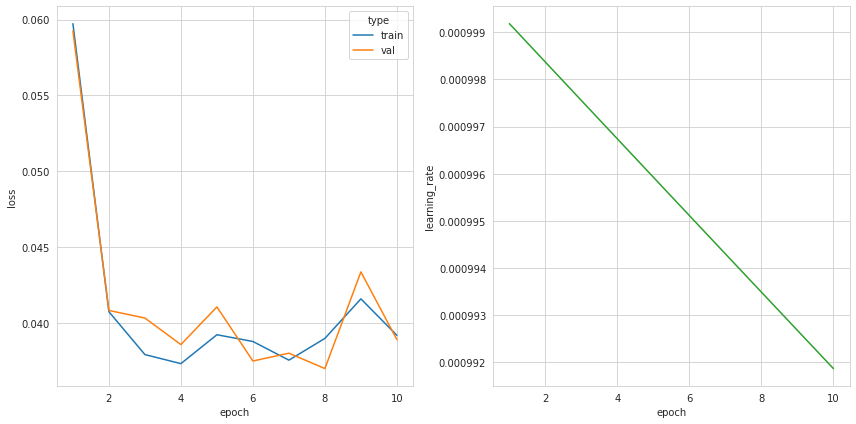

In [17]:
fig, axs = pyplot.subplots(1, 2, figsize=(12, 6))
df = P.wide_to_long(hist[['epoch', 'loss train', 'loss_std train', 'loss val', 'loss_std val']],
                    stubnames=['loss', 'loss_std'], i='epoch', sep=' ', j='type', suffix='\D+') \
    .reset_index()
seaborn.lineplot(x='epoch', y='loss', hue='type', data=df, ax=axs[0])
seaborn.lineplot(x='epoch', y='learning_rate', data=hist, ax=axs[1], color='tab:green')
fig.tight_layout()
fig.savefig(modelPath / 'training_history.png')

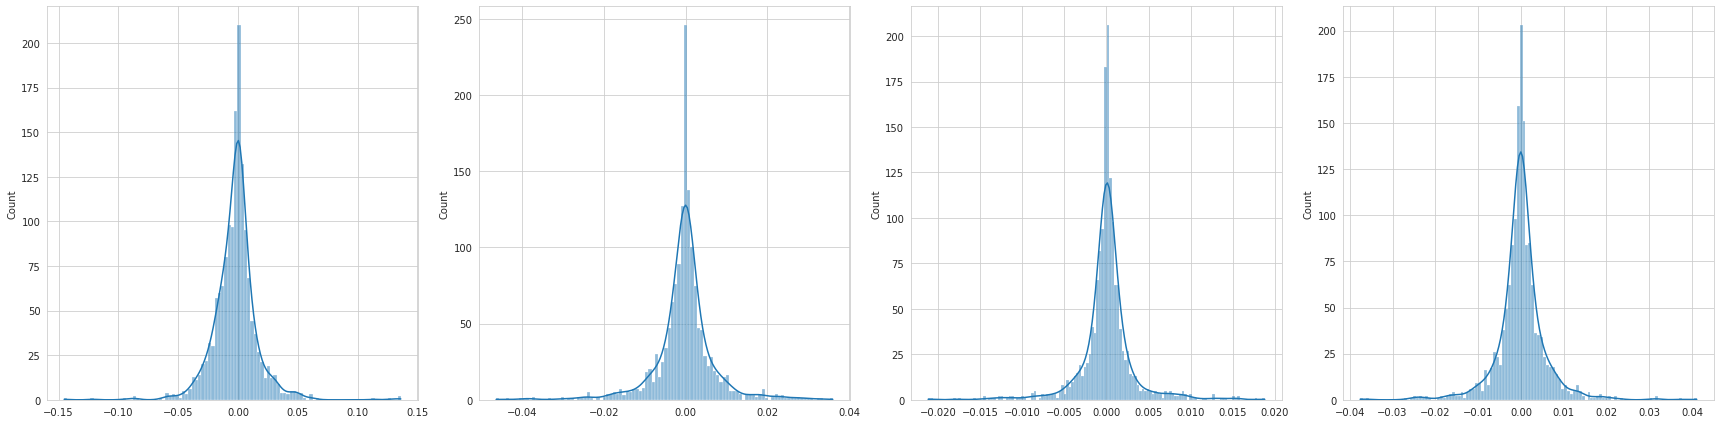

In [18]:
# Plot the gradient distributions
fig, axs = pyplot.subplots(1, 4, figsize=(24,6))
seaborn.histplot(histGradients[0], ax=axs[0], kde=True)
seaborn.histplot(histGradients[3], ax=axs[1], kde=True)
seaborn.histplot(histGradients[6], ax=axs[2], kde=True)
seaborn.histplot(histGradients[9], ax=axs[3], kde=True)
fig.tight_layout()
fig.savefig(modelPath / 'training_gradient_history.png')

# Performance Analytics

In [12]:
model.load(modelPath / 'epoch020')

In [13]:
# Evaluate on another set of option trajectories
nSamplesTest = 1024
with tf.device('/device:cpu:0'):
    NR.seed(config['seed']+1)
    strike = N.tile(N.linspace(config['strike'][0], config['strike'][1], 64, dtype='float32'), (nSamplesTest // 64,))
    option_test = FA.AmericanOption(nSamples=nSamplesTest,
                               nAssets=nAssets,
                               x0=1.0* N.ones((nSamplesTest,1),dtype='float32'),
                               strike=strike,
                               maturity=2.0 * N.ones((nSamplesTest,),dtype='float32'),
                               dividend=0.01 * N.ones((nSamplesTest,),dtype='float32'),
                               direction='put')
    option_test.populate()
    
l, (opt_v, opt_y), (list_loss, list_loss_arbitrage, list_z, flags) = model_eval(model, tf.range(0, nSamplesTest, dtype=tf.int32), option_test)
print(f"Total loss: {l:.3f}+{sum(model.core.losses):.3f}, List: {list_loss.mean():.3f}±{N.std(list_loss):.3f}")

Total loss: 8.198+0.000, List: 8.198±76.799


Distribution plots ...


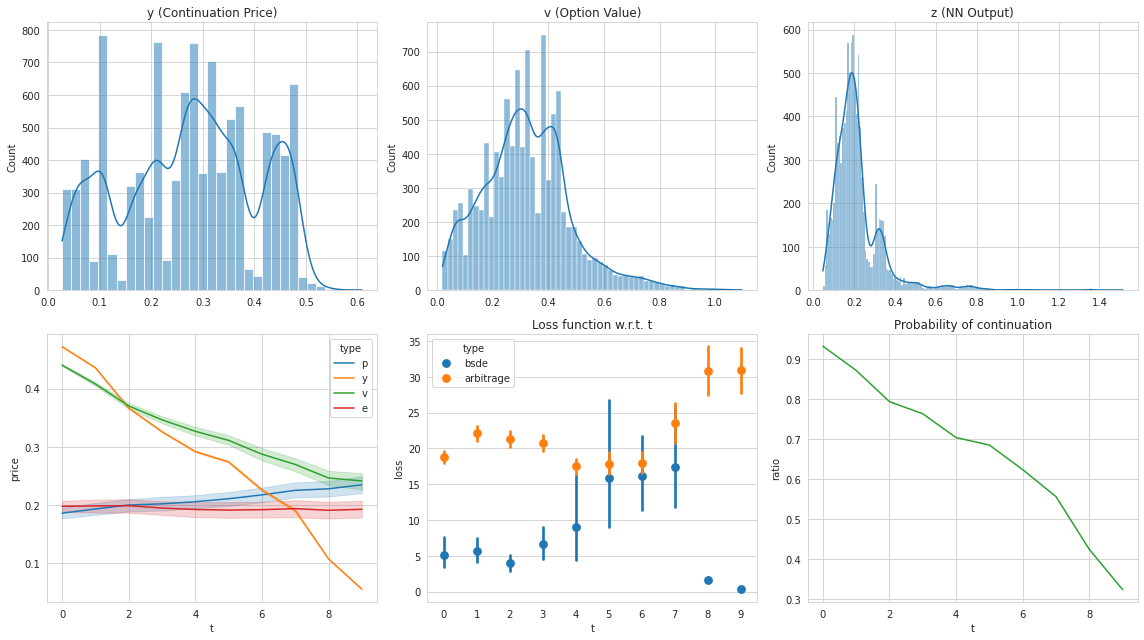

In [14]:
# Distributional checks
fig, axs = pyplot.subplots(2, 3, figsize=(16, 9))

idx = N.stack([range(option_test.nSteps)] * nSamplesTest).flatten()

print("Distribution plots ...")
# Plot the 3 main values
ax = axs[0][0]
seaborn.histplot(opt_y.flatten(), ax=ax, kde=True)
ax.set_title('y (Continuation Price)')
ax = axs[0][1]
seaborn.histplot(opt_v.flatten(), ax=ax, kde=True)
ax.set_title('v (Option Value)')
ax = axs[0][2]
seaborn.histplot(list_z.flatten(), ax=ax, kde=True)
ax.set_title('z (NN Output)')

ax = axs[1][0]
df = P.DataFrame({
    't': idx,
    'p': option_test.opt_p[:,:-1].flatten(),
    'y': opt_y.flatten(),
    'v': opt_v.flatten(),
    'e': option_test.opt_euro[:,:-1].flatten(),
}).melt(id_vars='t', var_name='type', value_name='price')
seaborn.lineplot(x='t', y='price', hue='type', data=df, ax=ax)

ax = axs[1][1]
df = P.DataFrame({'t': idx, 'bsde': list_loss.flatten(), 'arbitrage': list_loss_arbitrage.flatten()}).melt(id_vars='t', var_name='type', value_name='loss')
seaborn.pointplot(x='t', y='loss', hue='type', data=df, join=False, ax=ax)
ax.set_title('Loss function w.r.t. t')
ax = axs[1][2]
seaborn.lineplot(x='t', y='ratio', data=P.DataFrame({'t': range(option_test.nSteps), 'ratio': flags.mean(axis=0)}),
                 color='tab:green', ax=ax)
ax.set_title('Probability of continuation')

fig.tight_layout()
fig.savefig(modelPath / 'distplot.png')

Correlation plots ...


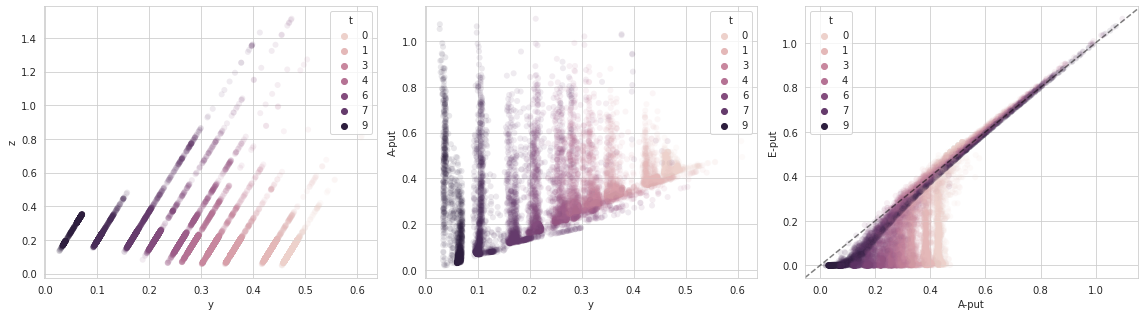

In [15]:
print("Correlation plots ...")

fig, axs = pyplot.subplots(1, 3, figsize=(16, 4.5))

# Plot the correlations
def scatterplot_step(names, vals, ax=None, diag=False):
    nameX, nameY = names
    valX, valY = vals
    df = P.DataFrame({'t': idx, nameX: valX.flatten(), nameY: valY.flatten()})
    graph = seaborn.scatterplot(x=nameX, y=nameY, hue='t', data=df, ax=ax, alpha=0.1, linewidth=0)
    if diag:
        assert ax
        ax.axline([0,0], [1,1], alpha=0.5, linestyle='--', color='k')
    #graph._legend.remove()
    
ax = axs[0]
scatterplot_step(['y', 'z'], [opt_y, list_z], ax=ax)
ax = axs[1]
scatterplot_step(['y', 'A-put'], [opt_y, opt_v], ax=ax)
ax = axs[2]
scatterplot_step(['A-put', 'E-put'], [opt_v, option_test.opt_euro[..., :-1]], ax=ax, diag=True)

fig.tight_layout()
fig.savefig(modelPath / 'corrplot.png')

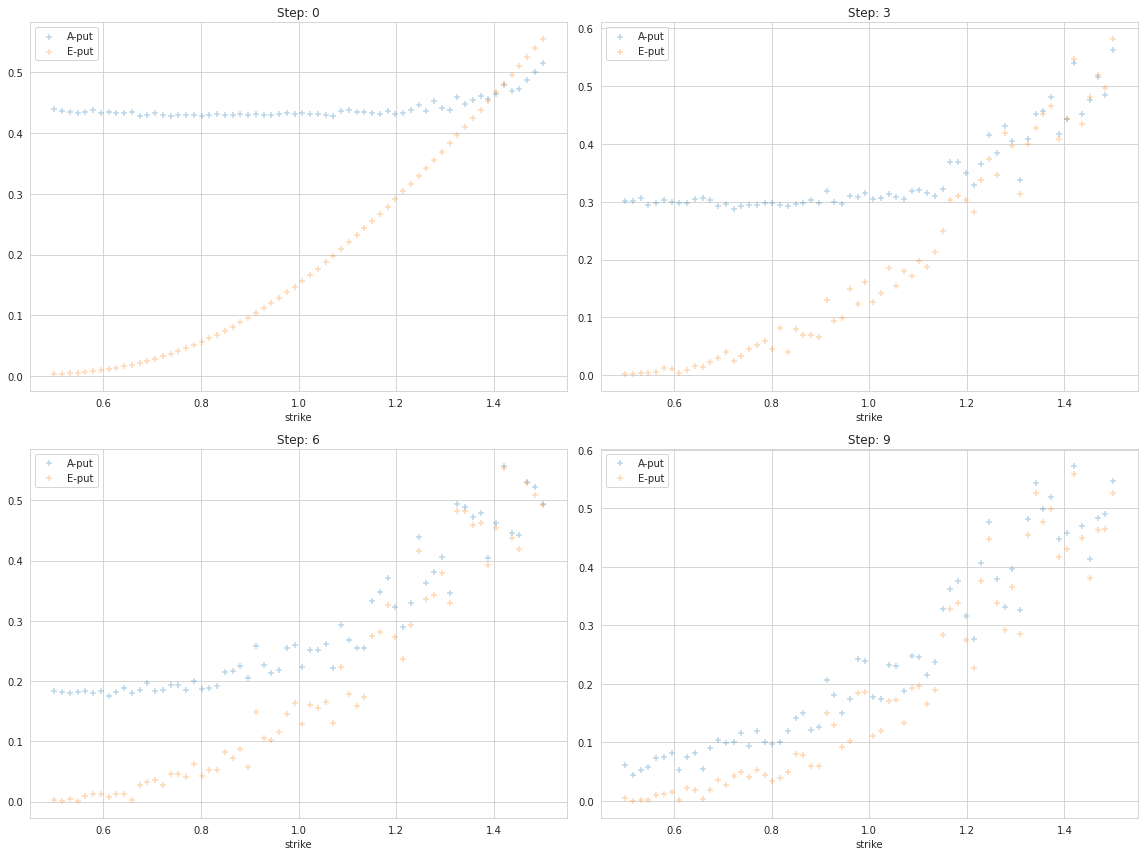

In [19]:
strikeGrid = strike.reshape((64, -1), order='F')

fig, axs = pyplot.subplots(2, 2, figsize=(16, 12))
for i,step in enumerate([0, 3, 6, 9]):
    ax = axs[i//2][i%2]
    
    opt_v_mean = opt_v[:,step].reshape((64, -1), order='F').mean(axis=-1)
    opt_e_mean = option_test.opt_euro[:,step].reshape((64, -1), order='F').mean(axis=-1)
#ax.scatter(strike, opt_v[:,0], marker='+', alpha=0.05, c='tab:green', label='A-put')
    ax.scatter(strikeGrid[:,step], opt_v_mean, marker='+', alpha=0.3, c='tab:blue', label='A-put')
    ax.scatter(strikeGrid[:,step], opt_e_mean, marker='+', alpha=0.3, c='tab:orange', label='E-put')
    ax.legend()
    ax.set_title(f"Step: {step}")
    ax.set_xlabel('strike')
fig.tight_layout()
fig.savefig(modelPath / 'compare-aput-eput.png')